# Convert CIF to JCPDS

## Input parameters

`cif` should exist in the `./cif` folder.  
`jcpds` will be created in the `./jcpds` folder.

In [1]:
%ls ./cif

Fe25O32_80GPa.cif       HP-Fe3O4_44GPa.cif      eta-Fe2O3_74GPa.cif
Fe2S.cif                MgSiO3_bm.cif           iota-Fe2O3_40.7GPa.cif
Fe4O5_10GPa.cif         Ni2S.cif                theta-Fe2O3_ 74GPa.cif
Fe5O6_11GPa.cif         Ni3S2.cif
Fe5O7_41GPa.cif         eta-Fe2O3_64GPa.cif


In [2]:
cif_name = 'Fe5O6_11GPa'

In [3]:
fn_cif = "./cif/"+cif_name+'.cif'
fn_jcpds = './jcpds/'+cif_name+'.jcpds'
comments_jcpds = cif_name

__(NOTE)__ Make sure the symmetry is not `P1` below.

In [4]:
!head {fn_cif}

data_Crystal
_audit_creation_method         'generated by CrystalMaker X for macOS'
_cell_length_a                   2.815000
_cell_length_b                   9.795000
_cell_length_c                  15.011000
_cell_angle_alpha               90.000000
_cell_angle_beta                90.000000
_cell_angle_gamma               90.000000

_symmetry_space_group_name_H-M     'C m c m'


Parameters for the equation of state of bridgmanite.

In [5]:
k0 = 200. # 200.
k0p = 4.00 # 4.
alpha = 3.16e-5 # 1.e-5

In [6]:
wl_xray = 0.3344
xrange = (0,40)

In [7]:
verbose = True

* This notebook shows how to calculate a theoretical diffraction pattern  using `pymatgen`.  
* This also aims to show how to read `CIF` files, convert them to `JCPDS`.  
* Some `jcpds` files can be downloaded from: https://github.com/SHDShim/JCPDS

In [8]:
%matplotlib inline

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import pymatgen as mg
from pymatgen import Lattice, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [11]:
if verbose:
    print(mg.__version__)

2019.7.30


This works with `pymatgen` version `2019.4.11` or later.

`ds_jcpds` is written by Dan Shim for making a jcpds file.

In [12]:
import sys
sys.path.append('../../peakpo/')
sys.path.append('../local_modules/')
import ds_jcpds
import quick_plots as quick

## Read CIF

The `cif` file below was downloaded from American mineralogist crystal structure database.

In [13]:
material = mg.Structure.from_file(fn_cif)

## Get some parameters in CIF

In [14]:
if verbose:
    print(material )

Full Formula (Fe20 O24)
Reduced Formula: Fe5O6
abc   :   2.815000   9.795000  15.011000
angles:  90.000000  90.000000  90.000000
Sites (44)
  #  SP      a       b       c
---  ----  ---  ------  ------
  0  Fe    0    0.6379  0.25
  1  Fe    0    0.3621  0.75
  2  Fe    0.5  0.1379  0.25
  3  Fe    0.5  0.8621  0.75
  4  Fe    0    0.1341  0.4527
  5  Fe    0    0.8659  0.9527
  6  Fe    0    0.1341  0.0473
  7  Fe    0    0.8659  0.5473
  8  Fe    0.5  0.6341  0.4527
  9  Fe    0.5  0.3659  0.9527
 10  Fe    0.5  0.6341  0.0473
 11  Fe    0.5  0.3659  0.5473
 12  Fe    0    0.3959  0.3568
 13  Fe    0    0.6041  0.8568
 14  Fe    0    0.3959  0.1432
 15  Fe    0    0.6041  0.6432
 16  Fe    0.5  0.8959  0.3568
 17  Fe    0.5  0.1041  0.8568
 18  Fe    0.5  0.8959  0.1432
 19  Fe    0.5  0.1041  0.6432
 20  O     0    0.29    0.25
 21  O     0    0.71    0.75
 22  O     0.5  0.79    0.25
 23  O     0.5  0.21    0.75
 24  O     0    0.782   0.421
 25  O     0    0.218   0.921
 26  O    

In [15]:
lattice = material.lattice
if verbose:
    print('Lattice parameters = ', lattice.a, lattice.b, lattice.c, \
          lattice.alpha, lattice.beta, lattice.gamma)
crystal_system = SpacegroupAnalyzer(material).get_crystal_system()
if verbose:
    print(crystal_system)

Lattice parameters =  2.815 9.795 15.011 90.0 90.0 90.0
orthorhombic


## Get diffraction pattern

In [16]:
c = XRDCalculator(wavelength=wl_xray)

In [17]:
pattern = c.get_pattern(material, two_theta_range = xrange)

## Extract twotheta, d-sp, int, hkl

In [18]:
pattern.hkls[0][0]['hkl']

(0, 0, 2)

In [19]:
pattern.hkls.__len__()

1000

In [20]:
h = []; k = []; l = []
for i in range(pattern.hkls.__len__()):
    h.append(pattern.hkls[i][0]['hkl'][0])
    k.append(pattern.hkls[i][0]['hkl'][1])
    l.append(pattern.hkls[i][0]['hkl'][2])

In [21]:
d_lines = [pattern.x, pattern.d_hkls, pattern.y, h, k, l ]
diff_lines = np.transpose(np.asarray(d_lines))
print(diff_lines[1,:])

[3.91290097 4.8975     0.22181316 0.         2.         0.        ]


## Table output

We can make a nice looking table using the `pandas` package.  `pandas` is more than looking-good table producer.  It is a powerful statistics package popular in data science.

In [22]:
table = pd.DataFrame(data = diff_lines,    # values
    columns=['Two Theta', 'd-spacing', 'intensity', 'h', 'k', 'l'])  # 1st row as the column names
table.head()

,Two Theta,d-spacing,intensity,h,k,l
0,2.552967,7.505500,1.724761,0.0,0.0,2.0
1,3.912901,4.897500,0.221813,0.0,2.0,0.0
2,4.115977,4.655961,0.111140,0.0,2.0,1.0
3,4.672634,4.101545,0.388349,0.0,2.0,2.0
4,5.107202,3.752750,0.005204,0.0,0.0,4.0


## Plot peak positions generated from pymatgen

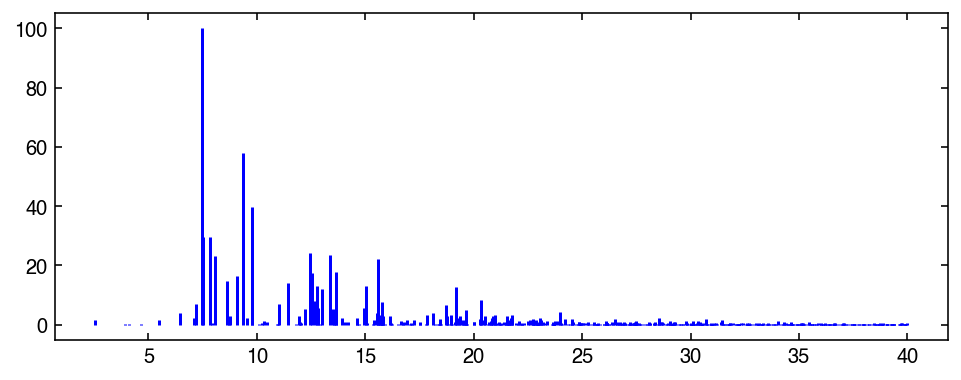

In [23]:
f, ax = plt.subplots(figsize=(8,3))
ax.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b');

## Convert to JCPDS

Setup an `jcpds` object from a `cif` file

In [24]:
material_jcpds = ds_jcpds.JCPDS()
material_jcpds.set_from_cif(fn_cif, k0, k0p, \
                      thermal_expansion=alpha, 
                        two_theta_range=xrange)

Calculate diffraction pattern at a pressure.

In [25]:
material_jcpds.cal_dsp(pressure = 100.)
dl = material_jcpds.get_DiffractionLines()
tth, inten = material_jcpds.get_tthVSint(wl_xray)

(7.5, 9)

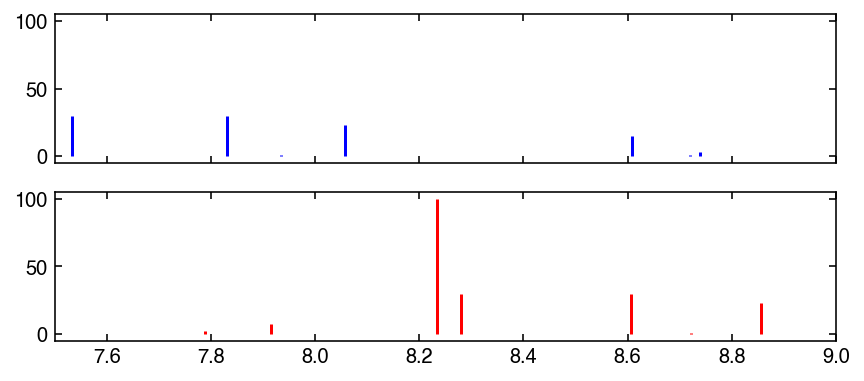

In [26]:
f, ax = plt.subplots(2, 1, figsize=(7,3), sharex=True)
ax[0].vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
ax[1].vlines(tth, 0., inten, color = 'r')
ax[0].set_xlim(7.5,9)

## Save to a JCPDS file

In [27]:
material_jcpds.write_to_file(fn_jcpds, comments=comments_jcpds)

In [28]:
!head {fn_jcpds}

4
Fe5O6_11GPa
4 200.00 4.00 
2.81500 9.79500 15.01100 
3.1600e-05 
d-spacing    I/I0     h   k   l 
7.505500 1.72 0.0 0.0 2.0 
4.897500 0.22 0.0 2.0 0.0 
4.655961 0.11 0.0 2.0 1.0 
4.101545 0.39 0.0 2.0 2.0 


# Read back the written JCPDS for test

In [29]:
material_test = ds_jcpds.JCPDS(filename = fn_jcpds)

Calculate a pattern at a pressure

In [30]:
material_test.cal_dsp(pressure = 100.)
material_test.get_DiffractionLines()
tth, inten = material_test.get_tthVSint(wl_xray)

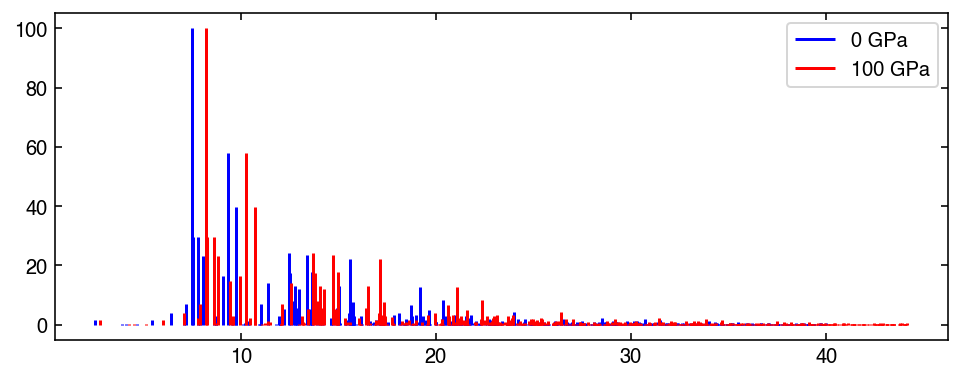

In [31]:
f = plt.figure(figsize=(8,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b', label='0 GPa')
plt.vlines(tth, 0., inten, color = 'r', label='100 GPa')
plt.legend();